In [1]:
# >>> imports <<< #
%matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt
from imusim.all import *
from scipy.interpolate import interp1d

seed = 12345
mmfit_data_dir = os.path.join(os.getcwd(), 'data/mm-fit')

In [147]:
# >>> joint <<< #
start = 100000
select_data = 3000
scale = 0.0001
joint_left_wrist = np.load(os.path.join(mmfit_data_dir, 'w00_joint_left_wrist.npy'))[:, start:start+select_data] * scale
joint_left_elbow = np.load(os.path.join(mmfit_data_dir, 'w00_joint_left_elbow.npy'))[:, start:start+select_data] * scale
actual_acc = np.load(os.path.join(mmfit_data_dir, 'w00_acc_left_wrist.npy'))[start:start+select_data, :]
timestamps = actual_acc[:, 1]
actual_acc = actual_acc[:, 2:]
sample_period = 0.01 # 100 Hz
# timestamps = np.arange(start=0, stop=joint_left_wrist.shape[1]) * sample_period

In [148]:
# >>> elbow-wrist direction <<< #
directions = joint_left_wrist - joint_left_elbow
norms = np.linalg.norm(directions, axis=0)
normalized_directions = directions / norms

In [149]:
# # >>> quaternion method 1 <<< #
# reference_vector = np.array([1, 0, 0]) # x-axis
# quaternions = []
# for i in range(normalized_directions.shape[1]): # for each sample
#     axis = np.cross(normalized_directions[:, i], reference_vector)
#     axis_normalized = axis / np.linalg.norm(axis)
#     cos_angle = np.dot(normalized_directions[:, i], axis_normalized)
#     angle = np.arccos(cos_angle)

#     q = QuaternionFromAxisAngle(axis_normalized, angle)
#     quaternions.append(q)

# quaternion_array = QuaternionArray(quaternions)

In [150]:
# # >>> quaternion method 2 <<< #
euler_angles = np.zeros((normalized_directions.shape[1], 3))
for i in range(normalized_directions.shape[1]):
    pitch = np.arctan2(normalized_directions[1, i], normalized_directions[2, i])
    roll = np.arctan2(normalized_directions[2, i], normalized_directions[0, i])
    roll = 0

    euler_angles[i] = [roll, pitch, 0]

euler_angles_degrees = np.degrees(euler_angles)

quaternion_array = QuaternionArray([QuaternionFromEuler(angle, order='zyx', inDegrees=True) for angle in euler_angles_degrees])

In [151]:
# # # # # >>> quaternion method 3 <<< #
# quaternions = []

# for i in range(normalized_directions.shape[1]):
#     x = normalized_directions[0, i]
#     y = normalized_directions[1, i]
#     z = normalized_directions[2, i]

#     q = QuaternionFromVectors(np.array([[x, 0, 0], [0, 1, 0], [0, 0, 1]]), np.array(
#         [[1, 0, 0], [0, y, 0], [0, 0, 1]]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, z]]))
#     quaternions.append(q)

# quaternion_array = QuaternionArray(quaternions)

In [152]:
sim = Simulation(seed=seed)
sampled = SampledTrajectory(
    TimeSeries(timestamps, joint_left_wrist),
    TimeSeries(timestamps, quaternion_array)
)
trajectory = SplinedTrajectory(sampled)
imu = IdealIMU(sim, trajectory)
behaviour = BasicIMUBehaviour(imu, sample_period)
sim.time = trajectory.startTime
sim.run(trajectory.endTime)

Simulating...
Simulated 1.5s of 29.9s (  5%). Estimated time remaining 0.6s
Simulated 3.0s of 29.9s ( 10%). Estimated time remaining 0.5s
Simulated 4.5s of 29.9s ( 15%). Estimated time remaining 0.4s
Simulated 6.0s of 29.9s ( 20%). Estimated time remaining 0.4s
Simulated 7.5s of 29.9s ( 25%). Estimated time remaining 0.4s
Simulated 9.0s of 29.9s ( 30%). Estimated time remaining 0.4s
Simulated 10.5s of 29.9s ( 35%). Estimated time remaining 0.3s
Simulated 12.0s of 29.9s ( 40%). Estimated time remaining 0.3s
Simulated 13.5s of 29.9s ( 45%). Estimated time remaining 0.3s
Simulated 15.0s of 29.9s ( 50%). Estimated time remaining 0.3s
Simulated 16.5s of 29.9s ( 55%). Estimated time remaining 0.3s
Simulated 18.0s of 29.9s ( 60%). Estimated time remaining 0.2s
Simulated 19.4s of 29.9s ( 65%). Estimated time remaining 0.2s
Simulated 20.9s of 29.9s ( 70%). Estimated time remaining 0.2s
Simulated 22.4s of 29.9s ( 75%). Estimated time remaining 0.1s
Simulated 23.9s of 29.9s ( 80%). Estimated time

In [153]:
sim_acc_time = np.round(imu.accelerometer.rawMeasurements.timestamps, 2)
sim_acc_val = imu.accelerometer.rawMeasurements.values

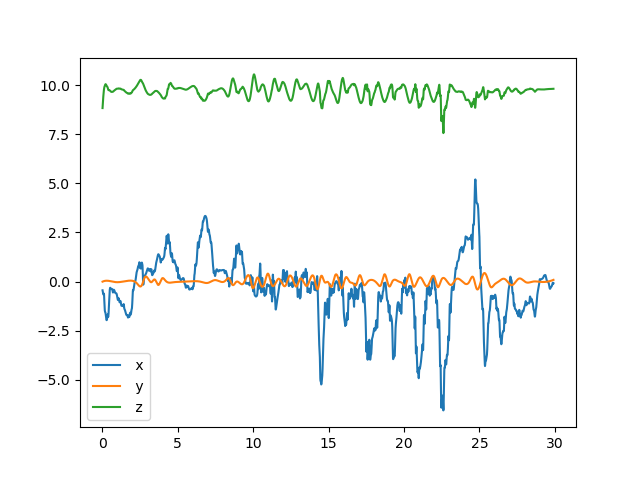

In [156]:
# >>> plot <<< #
plt.figure()
plot(imu.accelerometer.rawMeasurements)
plt.legend()
plt.show()

In [157]:
# interp_acc = np.zeros_like(sim_acc_val)
# for i in range(3):
#     interp = interp1d(timestamps, actual_acc[:, i])
#     interp_acc[i, :] = interp(sim_acc_time)

ValueError: A value (0.01) in x_new is below the interpolation range's minimum value (1000.0).

/var/folders/8z/lpg3p3tn2wv5xd2lshvn0rhw0000gn/T/ipykernel_2320/2977628332.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3, figsize=(10, 8))


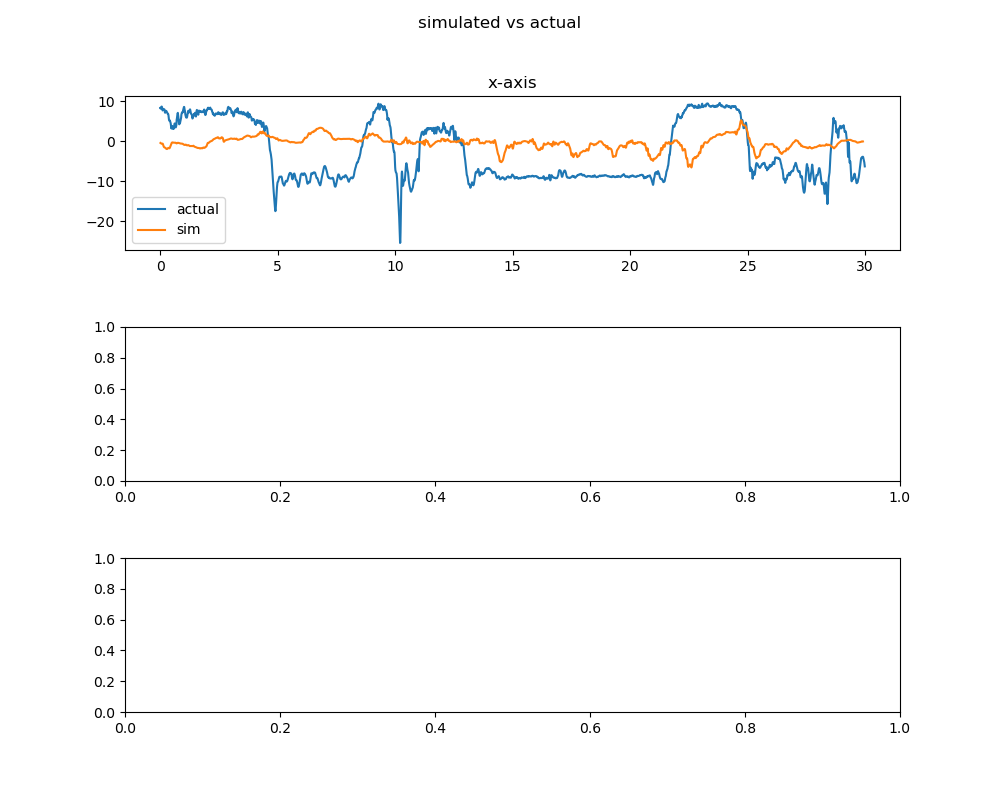

In [166]:
fig, ax = plt.subplots(3, figsize=(10, 8))

timestamps = timestamps - timestamps[0] 
ax[0].plot(timestamps, actual_acc[:, 0], label='actual')
ax[0].plot(sim_acc_time, sim_acc_val[0, :], label='sim')
ax[0].set_title('x-axis')
ax[0].legend()

# ax[1].plot(timestamps, actual_acc[:, 1], label='actual')
# ax[1].plot(sim_acc_time, sim_acc_val[1, :], label='sim')
# ax[1].set_title('y-axis')
# ax[1].legend()

# ax[2].plot(timestamps, -actual_acc[:, 2], label='actual')
# ax[2].plot(sim_acc_time, sim_acc_val[2, :], label='sim')
# ax[2].set_title('z-axis')
# ax[2].legend()

plt.subplots_adjust(hspace=0.5)  # Add space between subplots
plt.suptitle('simulated vs actual')
plt.show()

In [ ]:
select = np.arange(400, 600)

plt.figure()
# plot(TimeSeries(timestamps=acc_time[select], values=acc_values[0, select]))
# plot(imu.accelerometer.rawMeasurements)
plt.plot(sim_acc_time[select], sim_acc_val[0, select], label='simulated')
plt.plot(sim_acc_time[select], intersect_actual_acc[select, 2], label='actual')
plt.title('IMUSim Accelerometer')
plt.xlabel('time (s)')
plt.ylabel('acceleration (m/s^2)')
plt.legend()
plt.show()

In [ ]:
# >>> sanity check <<< #
velocity = np.gradient(wrist_joint, axis=1, edge_order=2) / sample_period
acceleration = np.gradient(velocity, axis=1, edge_order=2) / sample_period

In [ ]:
# Plotting the acceleration data
plt.figure(figsize=(10, 6))

# Plot each axis separately
plt.scatter(sim_acc_time[:], acceleration[0, :], label='X-axis')
# plt.plot(timestamps[:], acceleration[0, :], label='X-axis')
# plt.scatter(timestamps[select], acceleration[1, select], label='Y-axis')
# plt.scatter(timestamps[select], acceleration[2, select], label='Z-axis')

# Adding title and labels
plt.title('Derived Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

# Display the plot
plt.show()

In [ ]:
real_acc = np.load('data/w00_sw_l_acc.npy')[:3000, 2:] # shape (3000, 5)
acc_sample_rate = 0.01
timestamps = np.arange(start=0, stop=real_acc.shape[0]) * acc_sample_rate # shape (3000,)

In [ ]:
plt.figure(figsize=(10, 6))
select = np.arange(1500, 1650)
plt.scatter(acc_timestamps[select], real_acc[select, 0], label='X-axis')
# plt.scatter(acc_timestamps[select], real_acc[select, 1], label='Y-axis')
# plt.scatter(acc_timestamps[select], real_acc[select, 2], label='Z-axis')
plt.title('Real Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()

In [ ]:
real_acc = np.load('data/w00_sw_l_acc.npy')[:1000, :] # shape (3000, 5)

In [ ]:
start_time = real_acc[0, 1]
adjusted_timestamps = real_acc[:, 1] - \
    start_time  # make timestamps start from 0
# replace timestamps with adjusted timestamps
real_acc[:, 1] = adjusted_timestamps
acc_data = real_acc[:, 2:]
regular_acc_timestamps = np.arange(
    start=0, stop=real_acc.shape[0]) * acc_sample_rate

In [ ]:
regular_acc_data = np.array([np.interp(regular_timestamps, adjusted_timestamps, acc_data[:, i])
                                  for i in range(3)])

In [ ]:
# >>> random experiments <<< #
# random_time = randomTimeSequence()
# random_pose = randomPositionSequence(random_time)
# random_rotation = randomRotationSequence(random_time)
# random_time.shape, random_pose.shape, len(random_rotation)

In [ ]:
# >>> plot pose <<< #
# def plot_3d_pose(pose, elev=0, azim=0, figsize=(8, 8)):
#     """
#     Visualize a 3D skeleton.
#     :param pose: numpy array (3 x 17) with x, y, z coordinates with COCO keypoint format.
#     :param elev: Elevation angle in the z plane.
#     :param azim: Azimuth angle in the x, y plane.
#     :param figsize: Figure size.
#     :return: None
#     """
#     pose = pose.reshape(3, -1)  # Reshaping to 3 x 17 if not already in this shape
#     fig = plt.figure(figsize=figsize)
#     ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(elev, azim)

#     # Define connections between joints
#     limbs = [(0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6), (0, 7), 
#              (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), 
#              (8, 14), (14, 15), (15, 16)]

#     # Plot each limb
#     for limb in limbs:
#         x = [pose[0, limb[0]], pose[0, limb[1]]]
#         y = [pose[1, limb[0]], pose[1, limb[1]]]
#         z = [pose[2, limb[0]], pose[2, limb[1]]]
#         ax.plot(x, y, z, marker='o', markersize=2, lw=1)

#     # Setting axis labels
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')

#     plt.show()


# plot_3d_pose(joints_3dpose[:, 0, 1:]) # plot the first frame of all joints